<a href="https://colab.research.google.com/github/nefter/EDA/blob/master/Notebooks/Recomendaci%C3%B3n_de_libros_usando_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Problema:

Se quiere construir un sistema de recomendación de libros basado en los resumentes de los libros y los temas (topicos) de los mismos.

Para tal fin, se utiliza el [CMU Book Summary Dataset](https://www.cs.cmu.edu/~dbamman/booksummaries.html)

# Bibliotecas y funciones

In [1]:
!pip install --upgrade numpy==1.25.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 86.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
!pip install pyLDAvis  #biblioteca que extrae información de un modelo LDA para obtener una visualización interactiva

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 89.4 MB/s eta 0:00:00


In [3]:
# Para leer los datos
import csv
import json

import pandas as pd
import numpy as np
from collections import Counter # para contar frecuencias

# preprocesar texto
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Modelado de tópicos
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # al instalar pyLDAvis ocasiona un warning con ipkernel

In [4]:
import sklearn

for lib in [sklearn, pyLDAvis, np, pd]:
  print(lib.__name__, lib.__version__)



sklearn 1.6.1
pyLDAvis 3.4.0
numpy 2.0.2
pandas 2.2.2


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Lectura y exploración de datos

In [9]:
!tar -xzvf "/content/booksummaries.tar.gz" -C"/content/"

tar (child): /content/booksummaries.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = []

with open("/booksummaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in reader:
        data.append(row)

In [8]:
len(data)

16559

In [10]:
data[0]

['620',
 '/m/0hhy',
 'Animal Farm',
 'George Orwell',
 '1945-08-17',
 '{"/m/016lj8": "Roman \\u00e0 clef", "/m/06nbt": "Satire", "/m/0dwly": "Children\'s literature", "/m/014dfn": "Speculative fiction", "/m/02xlf": "Fiction"}',
 ' Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, \'Beasts of England\'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible Mr Jones from the farm, renaming it "Animal Farm". They adopt Seven Commandments of Animal-ism, the most important of which is, "All animals are equal". Snowball attempts to teach the animals reading and writing; food is plentiful, and the farm runs smoothly. The pigs elevate themselves to positions of leadership and set aside special food items, ostensibly for their personal health. Napoleon takes 

In [11]:
title = []
author = []
summary = []
for i in range(len(data)):
  title.append(data[i][2])
  author.append(data[i][3])
  summary.append(data[i][6])

datos = pd.DataFrame({ 'Title': title, 'Author': author,
                    'Summary': summary})
print(datos.shape)
datos.head(3)


(16559, 3)


,Title,Author,Summary
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,The text of The Plague is divided into five p...


In [12]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    16559 non-null  object
 1   Author   16559 non-null  object
 2   Summary  16559 non-null  object
dtypes: object(3)
memory usage: 388.2+ KB


In [13]:
datos[['Title', 'Author']].nunique()


,0
Title,16277
Author,4715


In [14]:
datos.Title.value_counts().head()

,count
Title,
Nemesis,6
Outcast,4
Haunted,4
Inferno,4
Exodus,3


 ¿por qué hay más de un resumen para cada titulo?

In [15]:
datos[datos.Title=='Nemesis']

,Title,Author,Summary
375,Nemesis,Isaac Asimov,The novel is set in an era in which interstel...
3499,Nemesis,Agatha Christie,Miss Marple receives a post card from the rec...
5157,Nemesis,Scott Ciencin,One of Fred's old friends from graduate schoo...
6159,Nemesis,Jo Nesbø,A bank robbery is committed by a lone robber ...
13696,Nemesis,Philip Roth,Nemesis explores the effect of a 1944 polio e...
13842,Nemesis,,"The story, set in Latium in AD 77, opens with..."


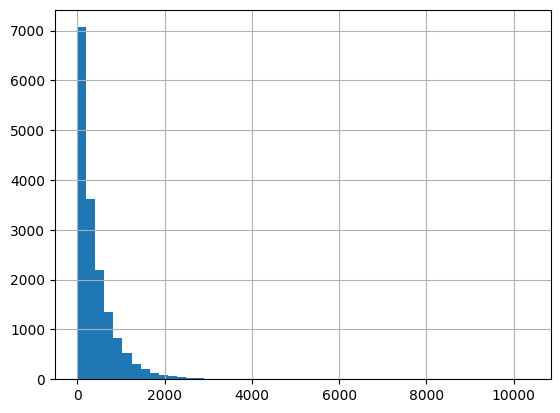

In [16]:
datos['len Summary'] = datos['Summary'].apply(lambda x: len(str(x).split()))
datos['len Summary'].hist(bins=50)
plt.show()

In [17]:

datos['len Summary'].describe(percentiles=[0.025, 0.05,0.10, 0.25,0.50, 0.75,0.90, 0.95, 0.975])

,len Summary
count,16559.000000
mean,429.202126
std,500.339692
min,1.000000
2.5%,29.000000
5%,44.000000
10%,64.000000
25%,120.000000
50%,263.000000
75%,569.000000


In [18]:
# Incluiremos en el dataset solamente resumentes con más de 30 palabras y menos de 1313 (sacrificando 7.5% de los datos)
quantile_025 = datos['len Summary'].quantile(0.025)
quantile_095 = datos['len Summary'].quantile(0.95)
filtro = (datos['len Summary'] > quantile_025) & (datos['len Summary'] < quantile_095)
df = datos[filtro].copy().reset_index(drop=True)
df.shape

(15297, 4)

# Obtener los tópicos principales

## Vectorización de textos

In [19]:
st = PorterStemmer()
stop_words = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def preprocesar(texto):
      # Convierte a minúsculas
      texto = (texto).lower()

      # Elimina stopwords
      texto = stop_words.sub('', texto)
      # Elimina puntuación y números
      texto = re.sub('[^a-z]+', ' ', texto)

      # Normalización y eliminación palabras que tengan menos de tres caracteres
      texto = texto.split()
      stemmed_words = [st.stem(i) for i in texto if len(i)>2]
      texto = ' '.join(stemmed_words)

      return(texto)

In [ ]:
# Este es el procesamiento, se deja en minúsculas, sin stop words y se hace steam

In [20]:
df['Summary_pp'] = df['Summary'].apply(preprocesar)
df.head()

,Title,Author,Summary,len Summary,Summary_pp
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",957,old major old boar manor farm call anim farm m...
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",998,alex teenag live near futur england lead gang ...
2,The Plague,Albert Camus,The text of The Plague is divided into five p...,1119,text plagu divid five part town oran thousand ...
3,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,722,novel posit space around milki way divid conce...
4,All Quiet on the Western Front,Erich Maria Remarque,"The book tells the story of Paul Bäumer, a Ge...",770,book tell stori paul umer german soldier urg s...


In [21]:
vectorizer = CountVectorizer(min_df=10, max_df =0.10,  ngram_range=(1,2))
BOW = vectorizer.fit_transform(df['Summary_pp'])
BOW.shape

(15297, 28929)

In [23]:
vectorizer = CountVectorizer(min_df=10, max_df =0.10,  ngram_range=(1,3))
BOW = vectorizer.fit_transform(df['Summary_pp'])
BOW.shape

(15297, 29479)

In [ ]:
vocabulario = vectorizer.get_feature_names_out()
len(vocabulario)

28929

In [24]:
vocabulario = vectorizer.get_feature_names_out()
len(vocabulario)

29479

In [25]:
vocabulario[375:400]

array(['afrikan', 'afterlif', 'aftermath', 'afternoon', 'afterward',
       'afterword', 'agamemnon', 'agatha', 'age die', 'age differ',
       'age eight', 'age eighteen', 'age father', 'age fifteen',
       'age five', 'age group', 'age man', 'age mother', 'age old',
       'age process', 'age stori', 'age ten', 'age thirteen', 'age three',
       'age twelv'], dtype=object)

## Entrenamiento del modelo

El número óptimo de topicos depende de las caracteristicas del texto a analizar (el largo de los textos, la cantidad de distintas ideas)

No obstante existen algunas metricas que ayudan a determinar k.

In [26]:
k = 13

Nota: La pregunta importante es "¿Cuál es el número adecuado para clusterizar?"

In [27]:

lda_model = LatentDirichletAllocation(n_components=k, learning_method='online',
                                      random_state=42, max_iter=30)

In [28]:
%%time
lda_model.fit(BOW) # entrena el modelo y obtienela matriz documento-topico

CPU times: user 2min 49s, sys: 126 ms, total: 2min 49s
Wall time: 2min 51s


LatentDirichletAllocation(learning_method='online', max_iter=30,
                          n_components=13, random_state=42)

### Guardamos modelo

In [29]:
import pickle
path = '/content/drive/MyDrive/Modelos/modelosLDA/LDA Books/'
tuple_models = (lda_model, BOW, vectorizer)
pickle.dump(tuple_models, open (path + "tuple_model_books_k13.pkl", 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Modelos/modelosLDA/LDA Books/tuple_model_books_k13.pkl'

In [ ]:
import pickle
path = '/content/drive/MyDrive/Modelos/modelosLDA/LDA Books/'
lda_model, BOW, vectorizer = pickle.load(open(path + "tuple_model_books_k13.pkl", 'rb'))


### Distribución de temas en cada resumen  ($β$)  n x k

In [30]:
lda_model.perplexity(BOW)

np.float64(8549.512973352388)

In [31]:
doc_top = pd.DataFrame(lda_model.transform(BOW))
print(doc_top.shape)
doc_top.head()

(15297, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000174,0.000174,0.000174,0.000174,0.000174,0.230172,0.000174,0.073712,0.000174,0.337905,0.345412,0.011407,0.000174
1,0.000159,0.000159,0.046769,0.000159,0.000159,0.000159,0.032481,0.000159,0.000159,0.371978,0.000159,0.451490,0.096014
2,0.000171,0.071166,0.052684,0.271558,0.055110,0.030028,0.038929,0.000171,0.086188,0.094371,0.007955,0.000171,0.291500
3,0.730608,0.069988,0.000230,0.135498,0.046884,0.009032,0.000230,0.006378,0.000230,0.000230,0.000230,0.000230,0.000230
4,0.000273,0.000273,0.000273,0.042118,0.432775,0.006644,0.075769,0.115497,0.151914,0.095076,0.000273,0.069269,0.009847


In [32]:
doc_top.sum(axis=1)

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
15292,1.0
15293,1.0
15294,1.0
15295,1.0


In [33]:
df_lda = pd.merge(df, doc_top, left_index=True, right_index=True)
df_lda.head(2)

,Title,Author,Summary,len Summary,Summary_pp,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",957,old major old boar manor farm call anim farm m...,0.000174,0.000174,0.000174,0.000174,0.000174,0.230172,0.000174,0.073712,0.000174,0.337905,0.345412,0.011407,0.000174
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",998,alex teenag live near futur england lead gang ...,0.000159,0.000159,0.046769,0.000159,0.000159,0.000159,0.032481,0.000159,0.000159,0.371978,0.000159,0.451490,0.096014


### Distribución de palabras en cada tema ($\theta$) k x d

In [34]:
word_distribution_topic = lda_model.components_ /lda_model.components_.sum(axis=1)[:, np.newaxis]
θs = pd.DataFrame(word_distribution_topic,
                         columns=vocabulario)
print(θs.shape)
θs

(13, 29479)


,aaron,aback,abandon,abandon citi,abandon famili,abandon home,abandon hous,abandon plan,abandon quest,abandon ship,...,zodiac,zoe,zoey,zola,zombi,zone,zoo,zuckerman,zulu,zurich
0,4.793443e-07,4.793421e-07,0.001030,6.537901e-05,4.793886e-07,4.793544e-07,4.793465e-07,4.793582e-07,4.793447e-07,1.174915e-04,...,7.090780e-05,4.793445e-07,4.793405e-07,4.793399e-07,1.381095e-03,1.121058e-03,1.628276e-04,4.793397e-07,4.793407e-07,4.793419e-07
1,4.896709e-07,4.897083e-07,0.000484,2.456345e-05,4.896792e-07,4.896835e-07,4.896710e-07,2.240073e-05,6.083437e-05,4.896806e-07,...,4.896688e-07,4.896693e-07,4.896714e-07,4.896683e-07,5.928873e-05,4.896711e-07,4.896753e-07,4.896671e-07,4.896710e-07,4.896688e-07
2,3.326501e-07,3.326620e-07,0.000774,3.326466e-07,3.326587e-07,3.326631e-07,3.326507e-07,4.459762e-05,3.326562e-07,3.326494e-07,...,3.326479e-07,3.326487e-07,3.326470e-07,3.326502e-07,3.326488e-07,3.326513e-07,3.326497e-07,3.326504e-07,3.326518e-07,3.326563e-07
3,5.336198e-07,5.336335e-07,0.000400,5.336256e-07,5.336709e-07,5.336418e-07,5.336263e-07,5.336289e-07,5.336193e-07,5.336203e-07,...,5.336200e-07,5.336178e-07,5.336181e-07,5.336206e-07,5.336223e-07,5.336212e-07,1.105306e-04,3.592575e-05,5.336381e-07,5.336172e-07
4,4.188146e-07,4.188268e-07,0.001172,4.188090e-07,4.188346e-07,4.188387e-07,4.188144e-07,4.188148e-07,4.188122e-07,4.188105e-07,...,4.188114e-07,4.188120e-07,4.188112e-07,7.123879e-05,4.188124e-07,4.188166e-07,2.227115e-06,4.188155e-07,4.188141e-07,4.188135e-07
5,2.311022e-03,1.470228e-06,0.000062,1.470223e-06,1.470238e-06,1.470274e-06,1.470234e-06,1.470223e-06,1.470240e-06,1.470232e-06,...,1.470241e-06,1.470223e-06,1.470217e-06,1.470232e-06,1.470273e-06,1.470232e-06,1.470231e-06,1.470227e-06,1.470226e-06,1.470235e-06
6,4.575436e-07,4.575449e-07,0.000473,4.575501e-07,4.575523e-07,4.575511e-07,4.575441e-07,4.575649e-07,4.575615e-07,4.575474e-07,...,4.575426e-07,4.575429e-07,4.575411e-07,4.575432e-07,4.575444e-07,4.575505e-07,4.575458e-07,4.575413e-07,9.843313e-05,4.575457e-07
7,6.422221e-07,6.422171e-07,0.000374,6.422150e-07,6.422218e-07,6.422235e-07,6.422144e-07,6.422276e-07,6.422583e-07,6.422712e-07,...,6.422179e-07,6.422149e-07,6.422122e-07,6.422123e-07,6.422154e-07,6.422235e-07,6.422170e-07,6.422126e-07,6.422153e-07,6.422199e-07
8,5.391682e-07,5.391846e-07,0.000783,5.391691e-07,5.392462e-07,5.391664e-07,5.391653e-07,5.391641e-07,5.391759e-07,5.391669e-07,...,5.391620e-07,5.391623e-07,5.391741e-07,5.391634e-07,5.391643e-07,5.391671e-07,5.391673e-07,5.391608e-07,5.391630e-07,5.391608e-07
9,2.572495e-07,2.572548e-07,0.000125,2.572485e-07,2.572624e-07,2.572624e-07,2.572492e-07,2.572521e-07,2.572522e-07,2.572502e-07,...,3.153877e-05,2.572484e-07,2.572476e-07,6.332041e-05,2.572503e-07,9.752961e-05,2.573591e-07,9.672344e-05,2.572491e-07,2.572496e-07


In [35]:
θs.sum(axis=1)

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [36]:
for top in range(k):
  print('\nPalabras más frecuentes del topico {}'.format(top))
  tokMasFrec = θs.T.loc[:,top].sort_values(ascending=False).head(10).index
  for tok in tokMasFrec:
      print(tok)


Palabras más frecuentes del topico 0
earth
planet
ship
space
alien
race
control
doctor
scientist
system

Palabras más frecuentes del topico 1
magic
dragon
villag
lord
island
wolf
dark
demon
forest
master

Palabras más frecuentes del topico 2
husband
mr
marriag
mari
letter
london
ladi
john
henri
sir

Palabras más frecuentes del topico 3
futur
exist
univers
earth
societi
creat
abil
develop
past
natur

Palabras más frecuentes del topico 4
job
paul
student
parent
money
class
teacher
high
charli
colleg

Palabras más frecuentes del topico 5
chapter
david
vampir
god
christian
ami
angel
gabriel
daniel
anita

Palabras más frecuentes del topico 6
king
armi
battl
soldier
slave
princ
empir
emperor
queen
prison

Palabras más frecuentes del topico 7
ship
captain
crew
command
island
unit
soviet
american
agent
mission

Palabras más frecuentes del topico 8
god
narrat
simon
word
dream
mountain
water
women
roman
voic

Palabras más frecuentes del topico 9
describ
author
write
narrat
american
polit
fictio

### Visualización del modelo

In [37]:
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

prepared_data = pyLDAvis.lda_model.prepare(lda_model, BOW, vectorizer)
display(prepared_data)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.094212  0.134408       1        1  13.459372
2      0.157453  0.010241       2        1  10.458382
12     0.026743 -0.071264       3        1   9.871987
11     0.167708 -0.120240       4        1   9.638840
4      0.144889  0.019814       5        1   8.141342
6     -0.133902 -0.032866       6        1   7.600194
0     -0.178649 -0.068529       7        1   7.291861
1     -0.008343 -0.121619       8        1   7.054226
3     -0.117814  0.104801       9        1   6.540434
8      0.077793  0.026361      10        1   6.458975
10     0.161597 -0.121796      11        1   5.699543
7     -0.245660 -0.112360      12        1   5.474807
5      0.042397  0.353049      13        1   2.310037, topic_info=          Term         Freq        Total Category  logprob  loglift
23396     ship  3771.000000  3771.000000  Default  30.0000  30.0000
4173   chapter  2116.000000  2116.000000  Default  29.0000  29.0000
13884     king  3335.000000  3335.000000  Default  28.0000  28.0000
7365     earth  2838.000000  2838.000000  Default  27.0000  27.0000
20105    polic  2256.000000  2256.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
20922   rachel   221.146298   556.486194  Topic13  -5.4554   2.8451
8578     faith   214.723719   606.441619  Topic13  -5.4849   2.7297
2901     blood   212.890113  1044.976031  Topic13  -5.4935   2.1769
13440     jean   172.593769   416.131496  Topic13  -5.7033   2.8878
11769     hell   163.755287   324.186683  Topic13  -5.7559   3.0850

[927 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
0         13  0.995546  aaron
28         1  0.054132   abil
28         4  0.011396   abil
28         5  0.001899   abil
28         6  0.001899   abil
...      ...       ...    ...
29447      6  0.980699   yuan
29468     10  0.986726    zeu
29471     11  0.993974   zoey
29473      7  0.958242  zombi
29473      8  0.038160  zombi

[2793 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 13, 12, 5, 7, 1, 2, 4, 9, 11, 8, 6])

In [ ]:
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

prepared_data = pyLDAvis.lda_model.prepare(lda_model, BOW, vectorizer)
display(prepared_data)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.020842  0.127435       1        1  14.713557
4     -0.172931  0.137005       2        1  13.766878
11    -0.054799 -0.021095       3        1  12.893125
2      0.161265  0.146696       4        1   9.946231
8      0.181960 -0.038020       5        1   8.465105
6     -0.102346  0.020196       6        1   7.893672
9      0.130936 -0.020057       7        1   6.559441
7     -0.146624  0.003251       8        1   6.179526
5     -0.021909 -0.153867       9        1   5.278184
1     -0.243691  0.120759      10        1   5.246081
12    -0.012452 -0.307833      11        1   3.434907
3      0.241340  0.138164      12        1   3.070381
10     0.018409 -0.152635      13        1   2.552912, topic_info=          Term         Freq        Total Category  logprob  loglift
13702     king  3361.000000  3361.000000  Default  30.0000  30.0000
23016     ship  3778.000000  3778.000000  Default  29.0000  29.0000
7281     earth  2842.000000  2842.000000  Default  28.0000  28.0000
19607   planet  2123.000000  2123.000000  Default  27.0000  27.0000
1324      armi  2300.000000  2300.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
26443     true   213.822410  1424.584330  Topic13  -5.5837   1.7714
16489     mind   200.483712  1546.537623  Topic13  -5.6481   1.6249
28        abil   192.682638  1046.019657  Topic13  -5.6878   1.9762
16255   memori   194.492557  1269.687661  Topic13  -5.6785   1.7918
20325  protect   182.955132  1352.307502  Topic13  -5.7396   1.6676

[896 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
22         8  0.994383     abel
28         1  0.243781     abil
28         3  0.257165     abil
28         4  0.027724     abil
28         5  0.086040     abil
...      ...       ...      ...
28817      6  0.005458     york
28817      9  0.032064     york
28901     11  0.986840  yuuzhan
28921      9  0.995840     zoey
28923      3  0.994962    zombi

[2654 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 12, 3, 9, 7, 10, 8, 6, 2, 13, 4, 11])

## Sistema de recomendación usando similitud coseno


<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1t6gQrFy1UMe_GtuGNDND90MqcebTeJD_" width="45%">
</p>

.

$$\text{similitud coseno}(A, B) = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} ~~~\sqrt{\sum_{i=1}^{n} B_i^2}}$$

In [38]:

def similitud_coseno(a_vector, b_vector):
    '''Calcula la similitud coseno entre los vectores a y b'''

    numerador = np.dot(a_vector, b_vector)

    a_norm = np.sqrt(np.sum(a_vector**2))
    b_norm = np.sqrt(np.sum(b_vector**2))

    denominador = a_norm * b_norm

    similitud_coseno = numerador / denominador

    return similitud_coseno

In [39]:
def documentos_similares(titulo):
  inx = df[df['Title']==titulo].index[0]
  q_k = doc_top.loc[inx].values
  n = doc_top.shape[0]
  similaridad = {}
  relevantes={}

  # Calcular similitud coseno
  for doc_inx in range(n):
      if doc_inx == inx:
          continue
      similaridad[doc_inx] = similitud_coseno(q_k, doc_top.loc[doc_inx].values)

  rank = {k:v for k,v in sorted(similaridad.items(), key=lambda x: x[1],
                                reverse=True)}
  top5= pd.DataFrame.from_dict(rank, orient = 'index', columns=['sim_cos']).head()
  recomendaciones = pd.merge(df.iloc[:,0:3], top5, how='right',  right_index=True, left_index=True)
  recomendaciones.index = np.arange(1, 6)

  return recomendaciones



In [40]:
documentos_similares('Dune')

,Title,Author,Summary,sim_cos
1,Times of Contempt,Andrzej Sapkowski,A coup in the Mages Guild ends with the Guild...,0.978202
2,Dune: House Corrino,Kevin J. Anderson,"One year after the War of Assassins, Duke Let...",0.968886
3,Assassin's Creed: Brotherhood,,'I will journey to the black heart of a corru...,0.963107
4,Halt's Peril,John Flanagan,"The book begins with Halt, Horace and Will di...",0.962563
5,A Darkness at Sethanon,Raymond E. Feist,"Arutha, Prince of Krondor, uses an attempted ...",0.958946


In [41]:
documentos_similares('The Time Machine')

,Title,Author,Summary,sim_cos
1,Candle,John Barnes,"Set in the year 2087, on a nearly crime-free ...",0.954453
2,The City of Ember,Jeanne DuPrau,"Unidentified architects, referred to as ""The ...",0.945680
3,Festival of Death,,'The Beautiful Death' is a theme park ride th...,0.935531
4,The Taking,Dean Koontz,"In the midst of an oddly sudden rain storm, a...",0.924731
5,Thief of Time,Terry Pratchett,The Auditors are upset because the human race...,0.920893
